In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from scipy import stats
from sklearn.preprocessing import MultiLabelBinarizer
import tqdm
import csv
import gensim
import random
from sklearn.decomposition import PCA

%config IPCompleter.greedy=True

## Data Retrieval

In [2]:
# DIRECTORY = '/Users/diyahirc/Files/BCM/genesets' # Change to your path
DIRECTORY = '/Users/diyahirc/Files/BCM Research/pathway25' # Change to your path

MINSETSIZE = 1

In [3]:
geneSetList = []

for fileName in os.listdir(DIRECTORY):
    if fileName == '.DS_Store':
        continue
    tempList = []
    tempPath = os.path.join(DIRECTORY, fileName)
    tempFile = open(tempPath,'r')
    print(tempPath)
    
    tempLines = tempFile.readlines()
    count = 0
    for line in tempLines:
        line = line.upper()
        line = line.strip('\n') 
        tempGeneSet = line.split('\t')[2:] # first two entries are 'geneSet name' and 'discription'   
        if len(tempGeneSet) >= MINSETSIZE:           # not interested in single gene'd gene sets
            geneSetList.append(tempGeneSet)

/Users/diyahirc/Files/BCM/pathway25/hsapiens_pathway_Wikipathway_genesymbol.gmt
/Users/diyahirc/Files/BCM/pathway25/hsapiens_pathway_Reactome_genesymbol.gmt
/Users/diyahirc/Files/BCM/pathway25/pathway25y.gmt
/Users/diyahirc/Files/BCM/pathway25/hsapiens_pathway_Panther_genesymbol.gmt
/Users/diyahirc/Files/BCM/pathway25/hsapiens_network_CORUM_genesymbol.gmt
/Users/diyahirc/Files/BCM/pathway25/hsapiens_pathway_KEGG_genesymbol.gmt


## Exploratory Data Analysis

In [4]:
def uniqueGenesInList(geneList):
    uniqueGenes = Counter()
    for geneSet in geneList:
        for gene in geneSet:
            uniqueGenes[gene] +=1
    return [uniqueGenes,len(uniqueGenes)]

In [5]:
TOTALGENESETCOUNT = len(geneSetList)

genesCount = []
geneSetCount = 0
for geneSet in geneSetList: 
    currentLength = len(geneSet)
    geneSetCount += 1
    genesCount.append(len(geneSet))

TOTALUNIQUEGENESCOUNT = uniqueGenesInList(geneSetList)[1]
print('Unique number of genes: {numUnique}'.format(numUnique = TOTALUNIQUEGENESCOUNT))
print(stats.describe(genesCount))

Unique number of genes: 16188
DescribeResult(nobs=64636, minmax=(1, 2694), mean=19.973869051302678, variance=1244.9137598023924, skewness=24.203494541055964, kurtosis=1249.281307703729)


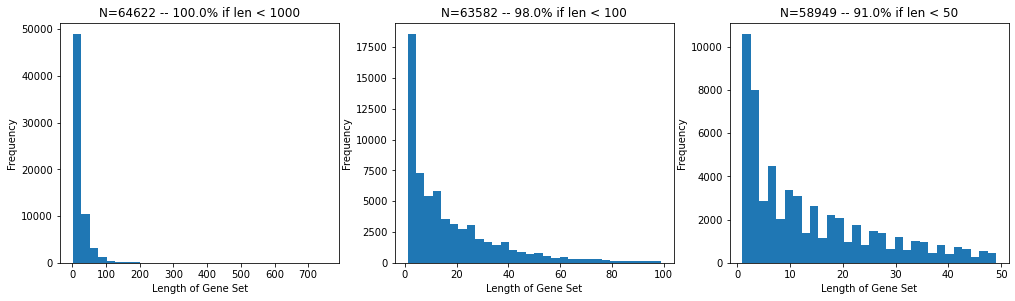

In [6]:
testLengths = [1000,100,50]
numTests = len(testLengths)
plt.figure(figsize=(17,15))
for index,testLength in enumerate(testLengths):
    genesCount = []
    geneSetCount = 0
    for geneSet in geneSetList: 
        currentLength = len(geneSet)
        if currentLength < testLength:
            geneSetCount += 1
            genesCount.append(len(geneSet))
    plt.subplot('{total}3{place}'.format(place=index+1,total=numTests))
    plt.hist(genesCount,bins=30)
    plt.xlabel('Length of Gene Set')
    plt.ylabel('Frequency')
    plt.title('N={total} -- {percent}% if len < {count}'.format(total=geneSetCount,
                                                                                         count=testLength,
                                                                                         percent=np.round(100*geneSetCount/TOTALGENESETCOUNT)))
plt.show()


### Ploting Effect of Setting a Maximum GS Length on Data Completeness

In [7]:
geneSetLengths = np.linspace(2,1000,40)
uniqueGenesCount = []
numberOfSetsCount = []
for maxGeneSetLength in geneSetLengths:
    genesCount = []
    filteredGeneSetList = []
    geneSetCount = 0
    for geneSet in geneSetList: 
        currentLength = len(geneSet)
        if currentLength < maxGeneSetLength:
            geneSetCount += 1
            filteredGeneSetList.append(geneSet)
    numberOfSetsCount.append(geneSetCount/TOTALGENESETCOUNT)
    uniqueGenesCount.append(uniqueGenesInList(filteredGeneSetList)[1]/TOTALUNIQUEGENESCOUNT)


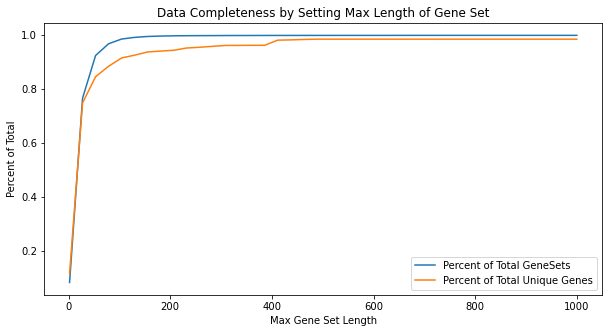

In [8]:
plt.figure(figsize=(10,5))
plt.plot(geneSetLengths,numberOfSetsCount, label='Percent of Total GeneSets')
plt.plot(geneSetLengths,uniqueGenesCount, label='Percent of Total Unique Genes')
plt.legend()
plt.xlabel('Max Gene Set Length')
plt.ylabel('Percent of Total')
plt.title('Data Completeness by Setting Max Length of Gene Set')
plt.show()

### Filter Data Set

In [31]:
# DataSet Hyper Parameters
MINSETLENGTH = 2
MAXSETLENGTH = 100
MINFREQUENCY = 2

In [32]:
def filterGS(GSList,minGeneFrequency,minGSLength,maxGSLength):
    # Filter out the genes that do not appear more than the min desired
    
    filteredGSMax = []
    # Filter out GS that go over max length
    for geneSet in GSList: 
        if len(geneSet) < maxGSLength:
            filteredGSMax.append(geneSet)
    GSList = filteredGSMax
    
    [genesCounterDict,numUnique] = uniqueGenesInList(GSList)   
    currentMinFrequency = min(genesCounterDict.values())
    
    # Need while loop since removing infrequent gene may bring geneset below min length
    while currentMinFrequency < minGeneFrequency:       
        newGS = []
        
        for geneSet in GSList:
            tempLength = len(geneSet)
            tempGeneSet = []
            # Reconstruct geneset with genes that appear more than min desired
            for index in range(tempLength): 
                tempGene = geneSet[index]
                if genesCounterDict[tempGene] > minGeneFrequency:
                    tempGeneSet.append(tempGene)

            if len(tempGeneSet) > minGSLength:
                newGS.append(tempGeneSet)
                
        [genesCounterDict,numUnique] = uniqueGenesInList(newGS)
        currentMinFrequency = min(genesCounterDict.values())
        GSList = newGS
        
    return GSList

DescribeResult(nobs=52899, minmax=(3, 99), mean=20.65114652450897, variance=348.8055929895892, skewness=1.5628336556531395, kurtosis=2.3512927421434613)


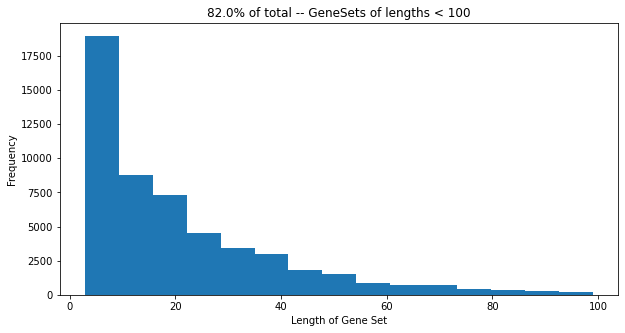

Unique number of genes: 11318 -- 70.0%


In [33]:
genesCount = []

filteredGeneSetList = filterGS(geneSetList,MINFREQUENCY,MINSETLENGTH,MAXSETLENGTH)

for geneSet in filteredGeneSetList: 
    genesCount.append(len(geneSet))

[genesCounterDict,NUMUNIQUE] = uniqueGenesInList(filteredGeneSetList)

print(stats.describe(genesCount))

plt.figure(figsize=(10,5))
plt.hist(genesCount,bins=15)
plt.xlabel('Length of Gene Set')
plt.ylabel('Frequency')
plt.title('{percent}% of total -- GeneSets of lengths < {count}'.format(count=MAXSETLENGTH,
                                                                        percent=np.round(100*len(filteredGeneSetList)/TOTALGENESETCOUNT)))
plt.show()

print('Unique number of genes: {numUnique} -- {percent}%'.format(percent=np.round(100*NUMUNIQUE/TOTALUNIQUEGENESCOUNT),
                                                                numUnique = NUMUNIQUE ))

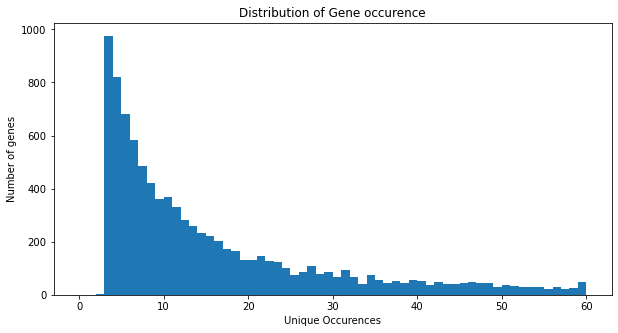

DescribeResult(nobs=11318, minmax=(2, 11275), mean=96.52102845025622, variance=176081.86608599706, skewness=12.810215576837283, kurtosis=225.17051047188144)


In [49]:
geneOccurenceCount = list(genesCounterDict.values())

plt.figure(figsize=(10,5))
plt.hist(geneOccurenceCount,60,(0,60))
plt.title('Distribution of Gene occurence')
plt.xlabel('Unique Occurences')
plt.ylabel('Number of genes')
plt.show()

print(stats.describe(list(geneOccurenceCount)))

## Using gensim to generate embedding

In [50]:
import gensim.models
random.shuffle(filteredGeneSetList)
model = gensim.models.Word2Vec(sentences=filteredGeneSetList,
                               min_count=2,
                               size=100,
                               compute_loss=True,
                               sg=0)

training_loss = model.get_latest_training_loss()
print(training_loss)

2872103.25


In [51]:
from gensim.models.keyedvectors import KeyedVectors

#convert binary gene2vec to matrix txt

def load_embeddings(file_name):
    model = KeyedVectors.load(file_name)
    wordVector = model.wv
    vocabulary, wv = zip(*[[word, wordVector[word]] for word, vocab_obj in wordVector.vocab.items()])
    return np.asarray(wv), vocabulary

def outputTxt (embeddings_file):
    embeddings_file = embeddings_file  # gene2vec file address
    wv, vocabulary = load_embeddings(embeddings_file)
    index = 0
    matrix_txt_file = embeddings_file+".txt"  # gene2vec matrix txt file address
    with open(matrix_txt_file, 'w') as out:
        for ele in wv[:]:
            out.write(str(vocabulary[index]) + "\t")
            index = index + 1
            for elee in ele:
                out.write(str(elee) + " ")
            out.write("\n")
    out.close()

In [71]:
import datetime

####training parameters########
dimension = 50  # dimension of the embedding
sg = 0  # sg =1, skip-gram, sg =0, CBOW
max_iter = 100  # number of iterations
txtOutput = True

training_losses = []

export_dir = "/Users/diyahirc/Files/BCM Research/trained_embeddings/pathway25/"
del model
for current_iter in tqdm.tqdm(range(1,max_iter+1)):
    if current_iter == 1:
        model = gensim.models.Word2Vec(filteredGeneSetList, size=dimension, min_count=2, iter=1, sg=sg, compute_loss=True)
        training_losses.append(model.get_latest_training_loss())
    else:
        current_time = datetime.datetime.now()
        random.shuffle(filteredGeneSetList)
        current_time = datetime.datetime.now()
        model.train(filteredGeneSetList,total_examples=model.corpus_count,epochs=model.iter, compute_loss=True)        
        training_losses.append(model.get_latest_training_loss())       
        if current_iter%5==0:
            model.save(export_dir+"gene2vec_dim_v2_"+str(dimension)+"_iter_"+str(current_iter)+'.model')
            if txtOutput:
                outputTxt(export_dir+"gene2vec_dim_v2_"+str(dimension)+"_iter_"+str(current_iter)+'.model')

  1%|          | 1/100 [00:02<04:42,  2.86s/it]<ipython-input-71-c8e6318180af>:21: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  model.train(filteredGeneSetList,total_examples=model.corpus_count,epochs=model.iter, compute_loss=True)
  5%|▌         | 5/100 [00:05<02:02,  1.29s/it]<ipython-input-71-c8e6318180af>:21: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  model.train(filteredGeneSetList,total_examples=model.corpus_count,epochs=model.iter, compute_loss=True)
 10%|█         | 10/100 [00:09<01:19,  1.14it/s]<ipython-input-71-c8e6318180af>:21: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  model.train(filteredGeneSetList,total_examples=model.corpus_count,epochs=model.iter, compute_loss=True)
 15%|█▌        | 15/100 [00:13<01:23,  1.02it/s]<ipython-input-71-c8e6318180af>:21: DeprecationWarning: C

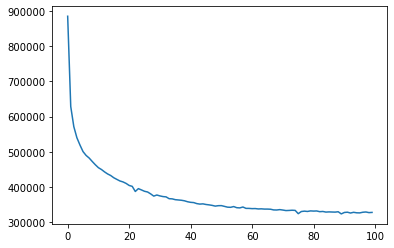

In [53]:
plt.plot(training_losses)
plt.show()

In [64]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

export_dir = "/Users/diyahirc/Files/BCM Research/trained_embeddings/pathway25/"

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  # fixed-width numpy strings
    
    pca = PCA(n_components=30)
    pca.fit(vectors)
    vectors=pca.transform(vectors)    
    print('PCA Complete')
    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0, perplexity=30)
    vectors = tsne.fit_transform(vectors)
    print('TSNE Complete')

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

model = gensim.models.Word2Vec.load(export_dir+"gene2vec_dim_v2_"+str(200)+"_iter_"+str(20)+'.model')

x_vals, y_vals, labels = reduce_dimensions(model)

PCA Complete
TSNE Complete


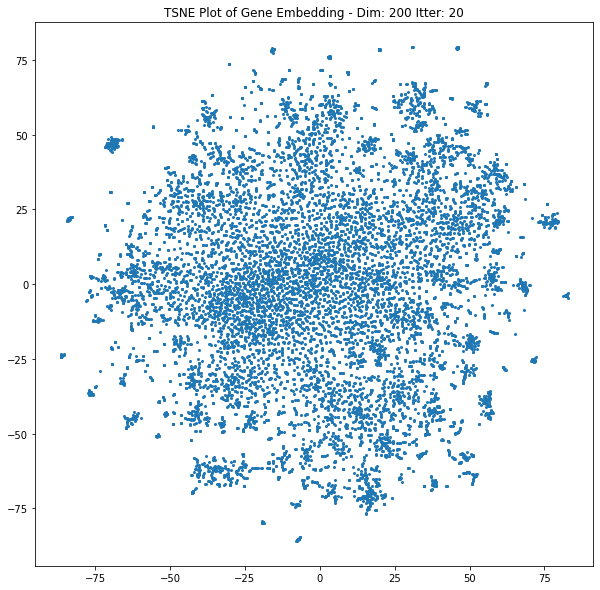

In [66]:
plt.figure(figsize=(10,10))
plt.title('TSNE Plot of Gene Embedding - Dim: 200 Itter: 20')
plt.scatter(x_vals,y_vals,s=4)
plt.show()

In [14]:
def getTargetCosineVals(dim,itters,targetFunc):
    tempVals = []
    
    for itteration in itters:
        temp_emb_w2v_file = "/Users/diyahirc/Files/BCM Research/trained_embeddings/pathway25/gene2vec_dim_v2_{dim}_iter_{itt}.model".format(dim=dim,itt=itteration)
        tempVals.append(targetFunc(temp_emb_w2v_file))
    
    return tempVals

In [ ]:
def getDenom():
    randArray = [] # Denominator in target function
    random.seed(35)
    random.shuffle(geneEmbedList)
    genePairs = list(itertools.combinations(geneEmbedList[:1000], 2))
    for pair in genePairs:
        sim = model.wv.similarity(pair[0], pair[1])
        randArray.append(sim)
    genePairs.clear()
    rand_mean = sum(randArray) / len(randArray)

    return rand_mean

In [2]:
import itertools

msig_sets = []
msigdb_file = "msigdb.v6.1.symbols.gmt" #update with your msigdb file address
pathwayList = []
with open(msigdb_file, 'r') as readFile:
    for line in readFile:
#         print(line)
        line = line.upper()
        line = line.strip('\n') 
        tmpList = line.split("\t")
        n = len(tmpList)
        if n > 52:
            continue
        pathwayList.append(line)
        msig_sets.append(set(tmpList[2:]))
        
readFile.close()
# print(pathwayList)

def targetFunc (emb_w2v_file):
    geneEmbedList = []
    with open(emb_w2v_file+'.txt', 'r') as file:
        for line in file:
            if len(line.split(" ")) == 2: # first line
                continue
            geneEmbedList.append((line.split('\t')[0]))
    file.close()
    model = gensim.models.Word2Vec.load(emb_w2v_file)
    paths_array = [] # Numerator in target function

    for pathway in pathwayList:
        geneList = list()
        path_arr = []
        tmpList = pathway.split("\t")
#         print(tmpList)
        n = len(tmpList)
        for i in range(2, n):
            if tmpList[i] in geneEmbedList:
                geneList.append(tmpList[i])
        genePairs = list(itertools.combinations(geneList, 2))
        for pair in genePairs:
            sim = model.wv.similarity(pair[0], pair[1])
            path_arr.append(sim)
        if(len(path_arr)>0):
            paths_array.append(sum(path_arr)/len(path_arr))
        tmpList.clear()
        geneList.clear()

    randArray = [] # Denominator in target function
    random.seed(35)
    random.shuffle(geneEmbedList)
    genePairs = list(itertools.combinations(geneEmbedList[:1000], 2))
    for pair in genePairs:
        sim = model.wv.similarity(pair[0], pair[1])
        randArray.append(sim)
    genePairs.clear()
    print("------------")
    print(emb_w2v_file)
    path_mean = sum(paths_array) / len(paths_array)
    rand_mean = sum(randArray) / len(randArray)
    print(path_mean,end="")
    print("\t",rand_mean)
    print(path_mean/rand_mean)
    print("------------")
    return path_mean / rand_mean

emb_w2v_file = "/Users/diyahirc/Files/BCM Research/trained_embeddings/alldata/gene2vec_dim_v2_200_iter_50.model"
targetFunc(emb_w2v_file)

------------
/Users/diyahirc/Files/BCM/trained_embeddings/alldata/gene2vec_dim_v2_200_iter_50.model
0.22204799569106845	 0.11529321956553136
1.9259414953266951
------------


1.9259414953266951

In [20]:
targetval = {}
dims = [50,100,150,200]
itters = np.arange(0,101,10)[1:] # Skip first initial untrained

results = [getTargetCosineVals(dim, itters,targetFunc) for dim in tqdm.tqdm(dims)]

  0%|          | 0/4 [00:00<?, ?it/s]

------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_50_iter_10.model
0.4112600933082058	 0.406039292735386
1.0128578703249347
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_50_iter_20.model
0.3155858103998783	 0.2666998071246361
1.183299732393119
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_50_iter_30.model
0.27648047820064114	 0.21184855981338285
1.3050854744738056
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_50_iter_40.model
0.25271379846343994	 0.18222928627869775
1.3867902554200022
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_50_iter_50.model
0.23529473639464263	 0.16216662807383242
1.450944249069025
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_50_iter_60.model
0.22241937112276486	 0.1470614166214

 25%|██▌       | 1/4 [06:11<18:34, 371.63s/it]

------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_50_iter_100.model
0.1901490471587432	 0.11208069260275313
1.6965370461501985
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_100_iter_10.model
0.4063073095809642	 0.3987973446333562
1.0188315319765042
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_100_iter_20.model
0.2947714147311107	 0.2459773676548516
1.1983680350003807
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_100_iter_30.model
0.2479751513087161	 0.19140735814616772
1.2955361471493199
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_100_iter_40.model
0.2197968218485254	 0.16286073150549146
1.3495998686528932
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_100_iter_50.model
0.19982685634953884	 0.1434477

 50%|█████     | 2/4 [12:38<12:32, 376.16s/it]

------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_100_iter_100.model
0.1508323704154024	 0.09767878255477125
1.5441671821700524
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_150_iter_10.model
0.4061657144488832	 0.40322027314406583
1.0073047946767424
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_150_iter_20.model
0.289609740362822	 0.24263151097748925
1.1936196547434075
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_150_iter_30.model
0.23772820667280015	 0.1858721004537949
1.2789881111387984
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_150_iter_40.model
0.20667504569022677	 0.1569806162843451
1.3165641120676213
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_150_iter_50.model
0.1854056844893329	 0.138188

 75%|███████▌  | 3/4 [18:56<06:16, 376.90s/it]

------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_150_iter_100.model
0.1358561244334462	 0.09462423887859435
1.4357433786891913
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_200_iter_10.model
0.4062346905711506	 0.39318312563876984
1.033194621237056
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_200_iter_20.model
0.2875209082052159	 0.23878991529980426
1.204074752672152
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_200_iter_30.model
0.2333566034090762	 0.1819713188078109
1.2823812287448217
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_200_iter_40.model
0.20084270227612114	 0.1529377028447039
1.3132321104630489
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_200_iter_50.model
0.1791715044182621	 0.13509437

100%|██████████| 4/4 [25:25<00:00, 381.38s/it]

------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_200_iter_100.model
0.12955463091006728	 0.09419387671364111
1.3754039586238331
------------


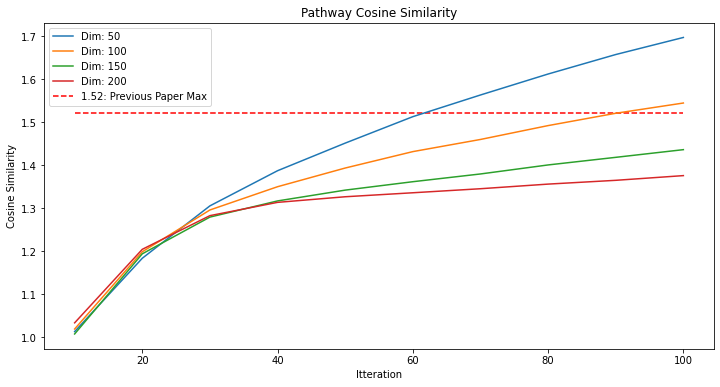

In [21]:
dims = [50,100,150,200]

plt.figure(figsize=(12,6))
for index in range(len(dims)):
    plt.plot(itters,results[index],label='Dim: '+str(dims[index]))

plt.hlines(1.52,itters[0],100,label='1.52: Previous Paper Max',colors='red',linestyles='dashed')
plt.title('Pathway Cosine Similarity')
plt.xlabel('Itteration')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.show()

In [22]:
resultsDf = pd.DataFrame(np.array(results))
indNames = {}
for ind,dim in enumerate(dims):
    indNames[ind] = dim

colNames = {}
for ind,itter in enumerate(itters):
    colNames[ind] = itter
    
resultsDf = resultsDf.rename(index=indNames, columns=colNames)
resultsDf.to_csv('simarlityDim.csv')
resultsDf.head()

,10,20,30,40,50,60,70,80,90,100
50,1.012858,1.183300,1.305085,1.386790,1.450944,1.512425,1.562822,1.611573,1.656863,1.696537
100,1.018832,1.198368,1.295536,1.349600,1.393028,1.431181,1.459446,1.491680,1.520347,1.544167
150,1.007305,1.193620,1.278988,1.316564,1.341685,1.361232,1.379247,1.400212,1.417892,1.435743
200,1.033195,1.204075,1.282381,1.313232,1.326269,1.335541,1.344931,1.355673,1.364479,1.375404


In [54]:
valDict = {}
for dimInd,maxInd in enumerate(np.argmax(results,axis=1)):
    valDict[dims[dimInd]] = [results[dimInd][maxInd],itters[maxInd]]

df = pd.DataFrame.from_dict(valDict, orient = 'index')
df = df.rename(columns={0:'Max Similarity Ratio',1:'Itteration'})
df.to_csv('maxResultDims.csv')
df.head()

,Max Similarity Ratio,Itteration
25,2.669594,100
50,2.543036,100
100,1.980481,100
150,1.798204,100
200,1.935211,60


# Lets see the intersection of the two datasets

In [23]:
dataSets = [set(geneSet) for geneSet in filteredGeneSetList]
intersectionCount = 0
for msigGeneSet in tqdm.tqdm(msig_sets):
    for dataGeneSet in dataSets:
        if msigGeneSet == dataGeneSet:
            intersectionCount += 1
print('Percentage overlap in geneSets: {perc}%'.format(perc = 100*intersectionCount/len(msig_sets)))

100%|██████████| 6963/6963 [00:30<00:00, 229.20it/s]

Percentage overlap in geneSets: 0.8329742926899325%


In [ ]:
targetval = {}
dims = [25,50,100,150,200]
itters = np.arange(0,101,5)[1:] # Skip first initial untrained

results = [getTargetCosineVals(dim, itters,targetFunc) for dim in tqdm.tqdm(dims)]

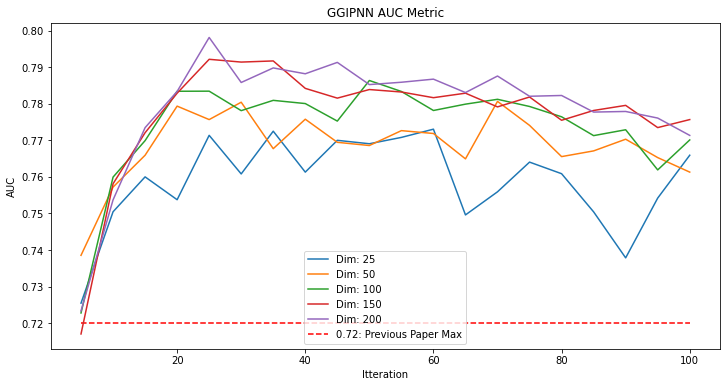

In [70]:
ppiResultsDf = pd.read_csv('/Users/diyahirc/Documents/BCM Research/gen2vec/Gene2vec/src/GGIPNNResults.csv')
dims = [25,50,100,150,200]
itters = np.arange(0,101,5)[1:] # Skip first initial untrained

results = ppiResultsDf.to_numpy()[:,1:]

plt.figure(figsize=(12,6))
plt.hlines(0.72,itters[0],100,label='0.72: Previous Paper Max',colors='red',linestyles='dashed')
for index in range(len(dims)):
    plt.plot(itters,results[index],label='Dim: '+str(dims[index]))

plt.title('GGIPNN AUC Metric')
plt.xlabel('Itteration')
plt.ylabel('AUC')
plt.legend()
plt.show()
plt.show()


# Exploring GeneSet Embeddings 

In [52]:
def geneSetVecAvg(geneSet,model):
    tempVec = np.zeros(200)
    for gene in geneSet:
        tempVec += model[gene]
    return tempVec/len(geneSet)

In [56]:
# Load model 
MODELPATH = "/Users/diyahirc/Documents/BCM Research/trained_embeddings/alldata/gene2vec_dim_v2_200_iter_60.model"
model = gensim.models.Word2Vec.load(MODELPATH)

geneSetAvgVectsList = []
for geneSet in filteredGeneSetList:
    geneSetAvgVectsList.append(geneSetVecAvg(geneSet,model))
    
geneSetAvgArray = np.array(geneSetAvgVectsList)

<ipython-input-52-ab94b90193ad>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  tempVec += model[gene]


In [57]:
print(geneSetAvgArray.shape)

(53711, 200)


In [67]:
uniques = np.unique(geneSetAvgArray,axis = 0)
print(uniques.shape[0] - geneSetAvgArray.shape[0])

-2925


In [68]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

export_dir = "/Users/diyahirc/Documents/BCM Research/trained_embeddings/alldata/"

def reduce_dimensions(model,vectors):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    if len(vectors) < 1: 
        vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index2word)  # fixed-width numpy strings
    
    pca = PCA(n_components=30)
    pca.fit(vectors)
    vectors=pca.transform(vectors)    
    print('PCA Complete')
    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0, perplexity=30)
    vectors = tsne.fit_transform(vectors)
    print('TSNE Complete')

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

# model = gensim.models.Word2Vec.load(export_dir+"gene2vec_dim_v2_"+str(200)+"_iter_"+str(60)+'.model')

x_vals, y_vals, labels = reduce_dimensions(model,uniques)

PCA Complete
TSNE Complete


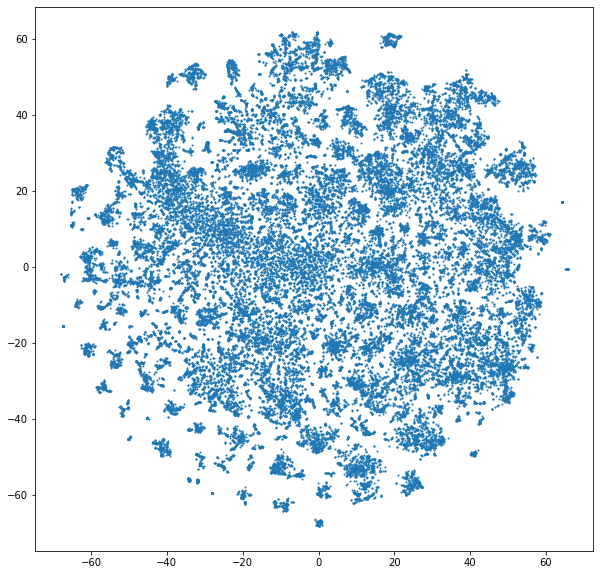

In [69]:
plt.figure(figsize=(10,10))
plt.scatter(x_vals,y_vals,s=1)
plt.show()

# Checking Coexpression Similarity

In [39]:
import itertools

coex_sets = []
coex_file = "coexp_pairs1.csv" #update with your msigdb file address
coexList = []
with open(coex_file, 'r') as readFile:
    for line in readFile:
#         print(line)
        line = line.upper()
        line = line.strip('\n') 
        tmpList = line.split(",")
        n = len(tmpList)
        if n > 52:
            continue
        coexList.append(tmpList)
        coex_sets.append(set(tmpList[2:]))
        
readFile.close()
print(len(coexList))

def targetFuncCoex(emb_w2v_file):
    geneEmbedList = []
    with open(emb_w2v_file+'.txt', 'r') as file:
        for line in file:
            if len(line.split(" ")) == 2: # first line
                continue
            geneEmbedList.append((line.split('\t')[0]))
    file.close()
    model = gensim.models.Word2Vec.load(emb_w2v_file)
    paths_array = [] # Numerator in target function

    for pair in coexList:
        geneList = list()
        path_arr = []
#         tmpList = pathway.split("\t")
#         print(tmpList)
#         n = len(tmpList)
#         for i in range(2):
        if len(pair) == 2:
            if pair[0] in geneEmbedList and pair[1] in geneEmbedList:
                geneList.append(pair)
            genePairs = geneList #list(itertools.combinations(geneList, 2))
            for pair in genePairs:
                sim = model.wv.similarity(pair[0], pair[1])
                path_arr.append(sim)
            if(len(path_arr)>0):
                paths_array.append(sum(path_arr)/len(path_arr))
            tmpList.clear()
            geneList.clear()

    randArray = [] # Denominator in target function
    random.seed(35)
    random.shuffle(geneEmbedList)
    genePairs = list(itertools.combinations(geneEmbedList[:1000], 2))
    for pair in genePairs:
        sim = model.wv.similarity(pair[0], pair[1])
        randArray.append(sim)
    genePairs.clear()
    print("------------")
    print(emb_w2v_file)
    path_mean = sum(paths_array) / len(paths_array)
    rand_mean = sum(randArray) / len(randArray)
    print(path_mean,end="")
    print("\t",rand_mean)
    print(path_mean/rand_mean)
    print("------------")
    return path_mean/ rand_mean

emb_w2v_file = "/Users/diyahirc/Files/BCM Research/trained_embeddings/alldata/gene2vec_dim_v2_200_iter_50.model"
targetFuncCoex(emb_w2v_file)

118964
------------
/Users/diyahirc/Files/BCM/trained_embeddings/alldata/gene2vec_dim_v2_200_iter_50.model
0.19579895463196742	 0.11529321956553136
1.6982694677953505
------------


1.6982694677953505

In [26]:
def getTargetSimVals(dim,itters,targetFuncCoex):
    tempVals = []
    
    for itteration in itters:
        temp_emb_w2v_file = "/Users/diyahirc/Files/BCM Research/trained_embeddings/pathway25/gene2vec_dim_v2_{dim}_iter_{itt}.model".format(dim=dim,itt=itteration)
        tempVals.append(targetFuncCoex(temp_emb_w2v_file))
    
    return tempVals

In [28]:
targetval = {}
dims = [50,100,150,200]

itters = np.arange(0,101,10)[1:] # Skip first initial untrained

results = [getTargetSimVals(dim, itters,targetFuncCoex) for dim in tqdm.tqdm(dims)]


  0%|          | 0/4 [00:00<?, ?it/s]

------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_50_iter_10.model
0.4758717544165898	 0.406039292735386
1.1719844924631797
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_50_iter_20.model
0.3549268930619	 0.2666998071246361
1.330810460226666
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_50_iter_30.model
0.3051942012561288	 0.21184855981338285
1.440624385291899
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_50_iter_40.model
0.27538170336435497	 0.18222928627869775
1.5111824723013612
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_50_iter_50.model
0.2536360474836297	 0.16216662807383242
1.5640458859892705
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_50_iter_60.model
0.23655441663993973	 0.14706141662145605



 25%|██▌       | 1/4 [04:07<12:21, 247.20s/it]

------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_50_iter_100.model
0.19429115575354225	 0.11208069260275313
1.7334935325762764
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_100_iter_10.model
0.4718753491357081	 0.3987973446333562
1.183245965615789
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_100_iter_20.model
0.3346814606064381	 0.2459773676548516
1.3606189211523458
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_100_iter_30.model
0.28053529229164786	 0.19140735814616772
1.4656452866217287
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_100_iter_40.model
0.2476573018296168	 0.16286073150549146
1.5206692217348052
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_100_iter_50.model
0.22407382234060294	 0.143447


 50%|█████     | 2/4 [08:26<08:21, 250.82s/it]

------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_100_iter_100.model
0.1635208511869775	 0.09767878255477125
1.6740672529910654
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_150_iter_10.model
0.46947425892042627	 0.40322027314406583
1.164312139515586
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_150_iter_20.model
0.3290242740499871	 0.24263151097748925
1.3560657176161803
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_150_iter_30.model
0.2702386054747737	 0.1858721004537949
1.4538954733658431
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_150_iter_40.model
0.2350160067776504	 0.1569806162843451
1.4971020775708814
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_150_iter_50.model
0.21065875499411038	 0.138188


 75%|███████▌  | 3/4 [12:49<04:14, 254.56s/it]

------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_150_iter_100.model
0.15165986147058325	 0.09462423887859435
1.6027591161411323
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_200_iter_10.model
0.47134141465794865	 0.39318312563876984
1.1987834266595292
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_200_iter_20.model
0.32885814269832364	 0.23878991529980426
1.377186060330217
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_200_iter_30.model
0.26762788100348106	 0.1819713188078109
1.470714631057526
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_200_iter_40.model
0.23051977102246887	 0.1529377028447039
1.5072788902586265
------------
------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_200_iter_50.model
0.20613676225481442	 0.135


100%|██████████| 4/4 [17:13<00:00, 258.30s/it]

------------
/Users/diyahirc/Files/BCM/trained_embeddings/pathway25/gene2vec_dim_v2_200_iter_100.model
0.1470197818041869	 0.09419387671364111
1.560821010171838
------------


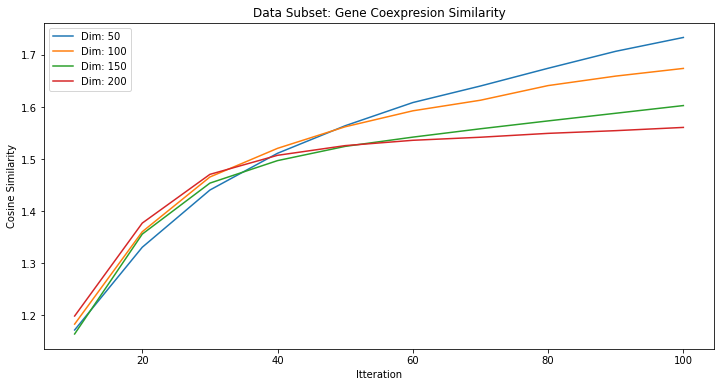

In [31]:
dims = [50,100,150,200]

plt.figure(figsize=(12,6))
for index in range(len(dims)):
    plt.plot(itters,results[index],label='Dim: '+str(dims[index]))

# plt.hlines(1.52,itters[0],100,label='1.52: Previous Paper Max',colors='red',linestyles='dashed')
plt.title('Data Subset: Gene Coexpresion Similarity')
plt.xlabel('Itteration')
plt.ylabel('Cosine Similarity')
plt.legend()
plt.show()